# SNR finder ANN model training

In [1]:
import numpy as np
import pandas as pd
from ler.utils import add_dict_values
import tensorflow as tf

# tf.config.threading.set_intra_op_parallelism_threads(6)
# tf.config.threading.set_inter_op_parallelism_threads(2)

## Get all necessary data

In [2]:
from ler.utils import append_json, get_param_from_json
import numpy as np

# these are pre-generated datas
# join all dictionaries into one
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['L1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
# unlensed_params['L1']<10000 => Error: 4.13%
# unlensed_params['L1']<100 => Error: 4.05%
# unlensed_params['L1']<50 => Error: 4.16%
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['L1'])

216908


216856

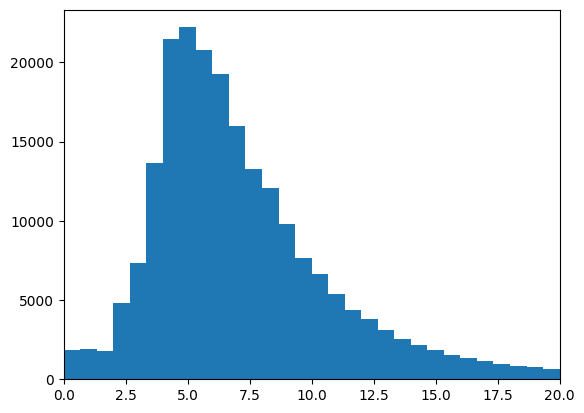

In [3]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [4]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


## Input-Output generator function

In [5]:
# from gwsnr import antenna_response_array, cubic_spline_interpolator2d

# def input_output(idx, params):

#     mass_1 = np.array(params['mass_1'])[idx]
#     mass_2 = np.array(params['mass_2'])[idx]
#     luminosity_distance = np.array(params['luminosity_distance'])[idx]
#     theta_jn = np.array(params['theta_jn'])[idx]
#     psi = np.array(params['psi'])[idx]
#     geocent_time = np.array(params['geocent_time'])[idx]
#     ra = np.array(params['ra'])[idx]
#     dec = np.array(params['dec'])[idx]
    
#     detector_tensor = gwsnr.detector_tensor_list
#     snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
#     ratio_arr = gwsnr.ratio_arr
#     mtot_arr = gwsnr.mtot_arr
    
#     size = len(mass_1)
#     len_ = len(detector_tensor)
#     mtot = mass_1 + mass_2
#     ratio = mass_2 / mass_1
#     # get array of antenna response
#     Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

#     Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
#     eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
#     A1 = Mc ** (5.0 / 6.0)
#     ci_2 = np.cos(theta_jn) ** 2
#     ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
#     size = len(mass_1)
#     snr_half_ = np.zeros((len_,size))
#     d_eff = np.zeros((len_,size))

#     # loop over the detectors
#     for j in range(len_):
#         # loop over the parameter points
#         for i in range(size):
#             snr_half_coeff = snr_halfscaled[j]
#             snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
#             d_eff[j,i] =luminosity_distance[i] / np.sqrt(
#                     Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
#                 )

#     #amp0
#     amp0 =  A1 / d_eff

#     # get spin parameters
#     a_1 = np.array(params['a_1'])[idx]
#     a_2 = np.array(params['a_2'])[idx]
#     tilt_1 = np.array(params['tilt_1'])[idx]
#     tilt_2 = np.array(params['tilt_2'])[idx]
#     # phi_12 = np.array(params['phi_12'])[idx]
#     # phi_jl = np.array(params['phi_jl'])[idx]

#     # effective spin
#     chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


#     # input data
#     # error=2.41%, 3.60%
#     # 4.93%, 3.46%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2]).T

#     # error=2.72%, 3.32%
#     # 4.73%, 3.19%
#     # 3.20%
#     # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
#     # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

#     # error=2.79%, 3.28%
#     # 4.46%, 3.18%
#     # 3.27%
#     XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
#     XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
#     XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

#     # output data
#     # get L1 snr for y train
#     yL1 = params['L1'][idx]
#     yH1 = params['H1'][idx]
#     yV1 = params['V1'][idx]

#     return(XL1, XH1, XV1, yL1, yH1, yV1)

In [6]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T 

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]

    return(XL1, yL1)

In [7]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, yL1 = input_output(idx, unlensed_params)
np.shape(XL1)

(216856, 4)

In [8]:
#concatenate XL1, yL1
data_new = np.concatenate((XL1, yL1[:,None]), axis=1)

## Scaling the data

In [9]:
XL1 = data_new[:,:-1]
yL1 = data_new[:,-1]

## L1

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [11]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [13]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [14]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [15]:
# 3m 29.6s multi-threading
# 3m 46.2s single-threading
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step - accuracy: 8.3891e-06 - loss: 16.6380
Epoch 2/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 1.8384e-05 - loss: 1.6141
Epoch 3/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 367us/step - accuracy: 1.9549e-05 - loss: 0.7583
Epoch 4/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 380us/step - accuracy: 2.2337e-05 - loss: 0.6012
Epoch 5/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 7.0169e-05 - loss: 0.6141
Epoch 6/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 2.4135e-05 - loss: 0.5698
Epoch 7/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 342us/step - accuracy: 4.0000e-05 - loss: 0.5674
Epoch 8/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step - accuracy: 1.1213e-05 - loss: 0.5679
Epoch 9/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 365us/step - accuracy: 5.7151e-05 - loss: 0.5592
Epoch 10/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 331us/step - accuracy: 3.7864e-05 - loss: 0.5440
Epoch 11/100
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 3

In [16]:
# Save the model to a file
ann.save('ann_modelL1_no_extra_scaling.h5')

In [33]:
from tensorflow.keras.models import load_model
# modelL1 = load_model('ann_modelL1_no_extra_scaling.h5')

In [34]:
y_pred = modelL1.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
[[ 5.26321507  5.2424983 ]
 [ 4.47142029  4.47856703]
 [ 3.38243818  3.05511991]
 [ 4.86401272  4.78211684]
 [ 3.1142652   3.13775806]
 [ 7.24734974  7.61543574]
 [ 4.15143013  3.28504019]
 [ 4.50670815  4.65370644]
 [ 3.15082622  3.01801802]
 [ 7.39093399  7.07858967]
 [10.64947987 10.33370743]
 [ 6.5050993   6.83812085]
 [ 7.6116724   6.62506512]
 [ 6.95489693  7.10678524]
 [ 5.93442535  6.05466682]]


In [35]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [36]:
X_, Y_ = input_output(np.arange(len(unlensed_params['L1'])), unlensed_params)
X_ = sc.transform(X_)

idx = (Y_>6)&(Y_<10)
y_pred = ann.predict(X_[idx])
y_true = Y_[idx]
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_true.reshape(len(y_true),1)),1)[:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
[[ 9.89567471  8.37264323]
 [ 6.36933756  6.08253142]
 [ 7.73420906  8.10900647]
 [ 6.83384037  6.53987562]
 [ 7.22859192  7.64317072]
 [ 6.41443634  6.45474988]
 [ 7.9500618   7.42176855]
 [ 6.77188969  6.43454205]
 [ 6.95174694  6.84108021]
 [ 6.58113194  6.45232595]
 [ 5.81172276  6.04834994]
 [ 8.1357832   8.06745302]
 [ 6.15501308  6.34537863]
 [ 6.59115028  7.3953399 ]
 [ 6.04848576  6.14583937]
 [ 7.14203548  7.36668992]
 [ 8.28619194  8.83326747]
 [ 4.96621704  6.58250399]
 [ 6.67010498  6.88068083]
 [ 5.84821701  6.00676755]
 [ 9.66589546  9.29325364]
 [ 9.3239193   7.13618657]
 [ 5.72079468  6.11026731]
 [ 6.57275009  6.45960054]
 [ 6.64291906  6.02239107]
 [ 9.13375378  7.90036234]
 [ 7.20563316  7.49219498]
 [ 8.03871632  8.48841842]
 [ 6.60565376  6.80922024]
 [ 7.57616043  7.14241753]
 [ 8.51705647  8.65667959]
 [ 7.79626274  8.19300083]
 [ 9.66185188  8.72468378]
 [ 9.67368793  8.88535465]
 [10.1775589   9.36444172]
 [ 9.56618023  9

In [37]:
np.where(np.round(Y_,8)==6.35281549)[0]

array([41804])

In [38]:
idxidx = 41804
X_[:,0][idxidx], X_[:,1][idxidx], X_[:,2][idxidx], X_[:,3][idxidx], unlensed_params['a_1'][idxidx], unlensed_params['a_2'][idxidx]

(0.0024239513994236722,
 -1.04110865804642,
 -3.7849327724746633,
 0.2398097037722366,
 0.5861459904631146,
 0.44975027363156717)

In [39]:
np.sum(X_[:,2]<-3)

770

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step
50000
115


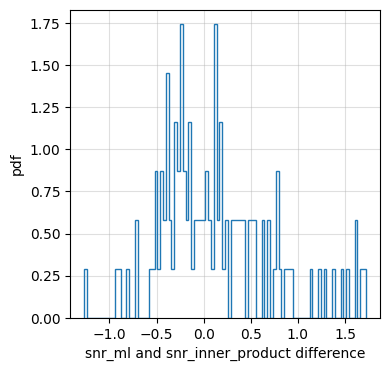

In [40]:
import matplotlib.pyplot as plt

y_pred_ = ann.predict(X_).flatten()
y_test_ = Y_
# y_test = Y_
hist_ = y_pred_-y_test_
print(len(hist_))
idx = (y_test_>6) & (y_test_<10)
idx = idx & (X_[:,2]>-2)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
# idx_ = abs(hist_)>3.0
# print(y_pred_[idx][idx_])
# print(y_test_[idx][idx_])
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
# plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [43]:
y_pred_ = ann.predict(X_).flatten()
y_test_ = Y_
len1 = len(y_pred_)
len2 = np.sum((y_pred_.flatten()>8) != (y_test_>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
Error: 0.0840%


21686
7753


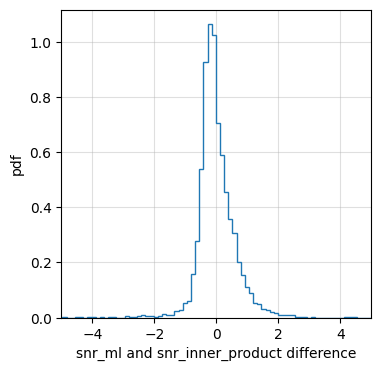

In [89]:
import matplotlib.pyplot as plt

y_pred = y_pred.copy().flatten()
# y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>6) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [41]:
# Save the model to a file
# ann.save('ann_modelL1.h5')

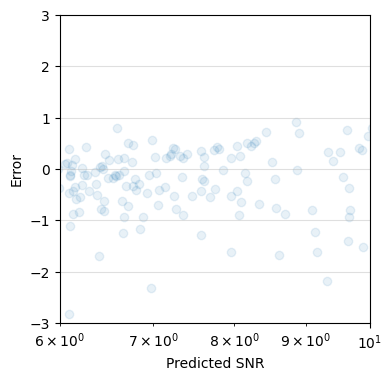

In [32]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
idx = (y_pred_>2) & (y_pred_<20)
# idx = idx & (X_[:,2]>-2)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test_[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.xlim(6,10)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## H1

In [496]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['H1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['H1']))

216908
216853


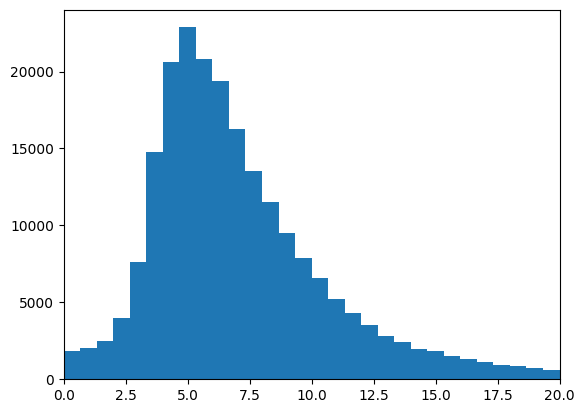

In [497]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['H1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [498]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['H1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['H1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [499]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XH1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get H1 snr for y train
    yH1 = params['H1'][idx]

    return(XH1, yH1)

In [500]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XH1, yH1 = input_output(idx, unlensed_params)
np.shape(XH1)

(216853, 5)

In [501]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [502]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [503]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [504]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


6099/6099 [==============================] - 3s 426us/step - loss: 6.0057 - accuracy: 1.0248e-05
Epoch 2/200
6099/6099 [==============================] - 3s 419us/step - loss: 1.0504 - accuracy: 2.5619e-05
Epoch 3/200
6099/6099 [==============================] - 3s 413us/step - loss: 0.7092 - accuracy: 4.0991e-05
Epoch 4/200
6099/6099 [==============================] - 3s 438us/step - loss: 0.6242 - accuracy: 4.0991e-05
Epoch 5/200
6099/6099 [==============================] - 3s 414us/step - loss: 0.5878 - accuracy: 1.5371e-05
Epoch 6/200
6099/6099 [==============================] - 3s 425us/step - loss: 0.5774 - accuracy: 3.5867e-05
Epoch 7/200
6099/6099 [==============================] - 3s 412us/step - loss: 0.5698 - accuracy: 3.0743e-05
Epoch 8/200
6099/6099 [==============================] - 3s 433us/step - loss: 0.5557 - accuracy: 3.0743e-05
Epoch 9/200
6099/6099 [==============================] - 3s 410us/step - loss: 0.5555 - accuracy: 3.0743e-05
Epoch 10/200
6099/6099 [=======

In [505]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 [==============================] - 0s 416us/step
[[35.00002289 37.97115266]
 [ 7.26647186  7.32079747]
 [ 5.22119141  5.49172148]
 [ 8.23579788  7.43225644]
 [ 9.9419899  10.75588391]
 [ 5.19015598  4.36140771]
 [10.4069252  10.10717316]
 [ 5.26541853  4.91636901]
 [ 4.82469225  4.77569326]
 [ 7.35954475  7.67734361]
 [ 3.12154722  3.37646147]
 [ 3.19977927  3.00987443]
 [14.30628777 15.10689954]
 [ 7.97162342  6.18384042]
 [ 9.09439564  8.87853961]]


In [506]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.02%


In [507]:
# Save the model to a file
ann.save('ann_modelH1.h5')

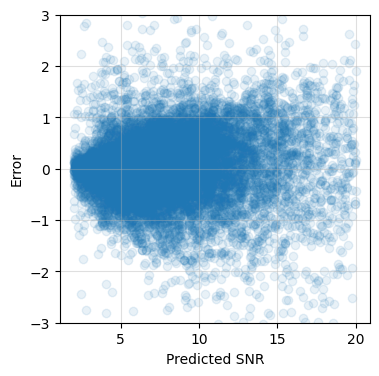

In [508]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred = y_pred.copy().flatten()
idx = (y_pred>2) & (y_pred<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred[idx], y_test[idx]-y_pred[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## V1

In [509]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['V1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['V1']))

216908
216879


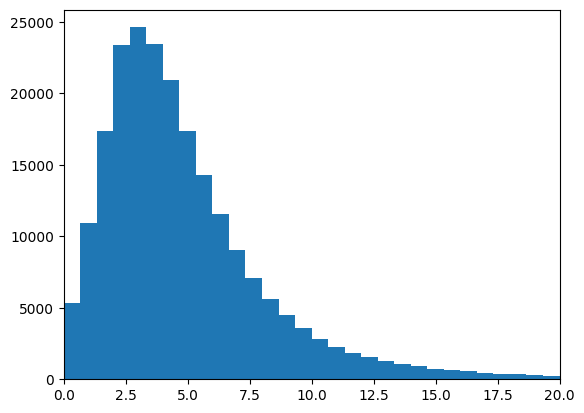

In [510]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['V1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [511]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['V1']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


In [512]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XV1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get V1 snr for y train
    yV1 = params['V1'][idx]

    return(XV1, yV1)

In [513]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XV1, yV1 = input_output(idx, unlensed_params)
np.shape(XV1)

(216879, 5)

In [514]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [515]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [516]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [517]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=8, use_multiprocessing=True)

Epoch 1/200


6100/6100 [==============================] - 3s 430us/step - loss: 4.7937 - accuracy: 2.5616e-05
Epoch 2/200
6100/6100 [==============================] - 3s 441us/step - loss: 1.0596 - accuracy: 3.0739e-05
Epoch 3/200
6100/6100 [==============================] - 3s 425us/step - loss: 0.6419 - accuracy: 3.5862e-05
Epoch 4/200
6100/6100 [==============================] - 3s 447us/step - loss: 0.4850 - accuracy: 3.0739e-05
Epoch 5/200
6100/6100 [==============================] - 3s 417us/step - loss: 0.4213 - accuracy: 2.5616e-05
Epoch 6/200
6100/6100 [==============================] - 3s 440us/step - loss: 0.3833 - accuracy: 1.5370e-05
Epoch 7/200
6100/6100 [==============================] - 3s 420us/step - loss: 0.3560 - accuracy: 3.0739e-05
Epoch 8/200
6100/6100 [==============================] - 3s 434us/step - loss: 0.3462 - accuracy: 3.5862e-05
Epoch 9/200
6100/6100 [==============================] - 3s 417us/step - loss: 0.3355 - accuracy: 1.5370e-05
Epoch 10/200
6100/6100 [=======

In [518]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 [==============================] - 0s 335us/step


[[13.49041462 13.5532527 ]
 [ 4.03706074  4.11572358]
 [ 8.59361839  7.79521397]
 [ 2.1222508   2.16101504]
 [ 4.0793047   4.08103545]
 [ 2.22639751  2.08412741]
 [ 8.18501854  6.70793353]
 [ 5.5151701   5.41165149]
 [ 4.33706999  3.41114713]
 [ 2.18644643  2.22421085]
 [ 4.75796366  9.33814207]
 [ 3.4946394   3.29469341]
 [ 3.73273301  3.8705105 ]
 [ 5.85980892  6.1987328 ]
 [ 6.52721453  6.81462945]]


In [519]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.98%


In [520]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [521]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

## BBH

In [522]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds


You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10

In [523]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(np.array(params['L1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y)

In [524]:
# generating new data
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

In [525]:
## Uncomment to generate new data if not already generated
size_ = 25000
ler.batch_size = 25000
ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

unlensed params will be store in ./ler_data/unlensed_param_testing.json
chosen batch size = 25000 with total size = 25000
There will be 1 batche(s)
resuming from ./ler_data/unlensed_param_testing.json
saving all unlensed_params in ./ler_data/unlensed_param_testing.json...


In [526]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [527]:
X_, Y_ = input_output_net(np.arange(size_), unlensed_params)

In [528]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [529]:
_, snrANN =input_output_netANN(X_)

782/782 [==============================] - 0s 261us/step


In [530]:
y_pred = snrANN.flatten()
y_test = Y_

In [531]:
len(y_test)

25000

In [532]:
len(y_pred)

25000

In [563]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred>4) & (y_pred<12)
popt, pcov = curve_fit(func, y_pred[idx], y_pred[idx]-y_test[idx])
print(popt)

[-0.07411881  0.87044046]


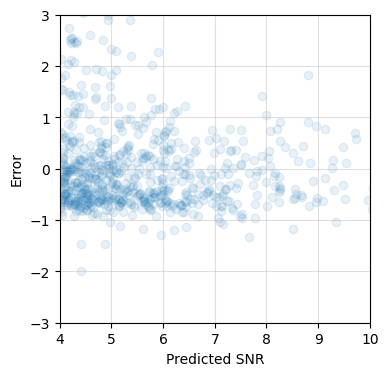

In [564]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred = y_pred.copy().flatten()
y_pred = y_pred-(popt[0]*y_pred+popt[1])
idx = (y_pred>4) & (y_pred<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred[idx], y_pred[idx]-y_test[idx], alpha=0.1)
#plt.scatter(y_test[idx], y_pred[idx]-y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

25000
777


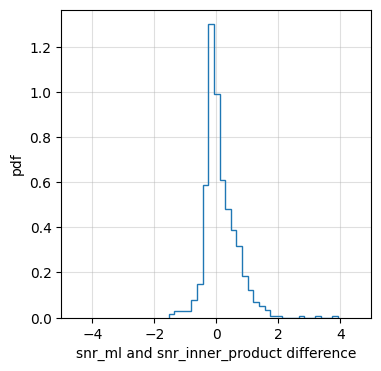

In [565]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [562]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1120%


In [566]:
len1 = len(y_pred)
len2 = np.sum(((y_pred-(popt[0]*y_pred+popt[1]))>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1040%


In [567]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.0)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24869    18]
 [   10   103]]


0.99888

In [568]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.2)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24875    12]
 [   14    99]]


0.99888

In [569]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_pred<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1)-0.2, y_test.reshape(len(y_test),1)),1)[idx][:10])

[[6.98862362 7.3244188 ]
 [8.07498264 8.73664642]
 [8.58827877 9.05212486]
 [6.86917257 7.01070622]
 [7.88767624 8.33806557]
 [7.8469162  8.45750222]
 [8.56952381 8.94146165]
 [8.12943077 7.33984516]
 [7.83821392 7.59029936]
 [6.58561087 7.04858059]]


## BNS

In [540]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [541]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


  1%|▌                                                          | 527/50000 [00:10<17:00, 48.47it/s]


KeyboardInterrupt: 

In [ ]:
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined